## Workshop 2: Mixed Integer Linear Program Exercise

### 1. Installing and Importing Packages 

We first need to pull in all the packages we will be using. Pyomo is a Python-based, open-source optimization modelling language with a diverse set of optimization capabilities. For more information, see the Pyomo [documentation](https://pyomo.readthedocs.io/en/stable/).

In [22]:
# Only run once at the start
!pip install -q pyomo
!pip install -q matplotlib

In [23]:
import matplotlib.pyplot as plt
from pyomo.environ import *
import numpy as np
from ipywidgets import FloatSlider, interact, widgets
import platform
from IPython.display import display

# Ipopt solver setup for Windows or Linux
def setup_solver():
    os_name = platform.system()
    if os_name == "Windows":
        return "solver/ipopt.exe"
    elif os_name == "Linux":
        !chmod +x "solver/ipopt"
        return "solver/ipopt"


solver_executable = setup_solver()

### 2. Simple MILP Problem Formulation

$$
\text{minimize} \quad -x_1 - x_2
$$

$$
\text{s.t.} -x_1 + x_2 \geq 0 
$$

$$

$$

$$
x_1 \leq 2 
$$

$$
x_2 \leq 3 
$$

$$
x_1, x_2 \in \mathbb{Z}^+ 
$$



In [67]:
# Create a model
model = ConcreteModel()

# Define decision variables as integers
model.x1 = Var(domain=NonNegativeIntegers)
model.x2 = Var(domain=NonNegativeIntegers)

# Objective function
model.obj = Objective(expr=-model.x1 - model.x2, sense=minimize)

# Constraints
model.constraint1 = Constraint(expr=-model.x1 + model.x2 >= 0)
model.constraint2 = Constraint(expr=model.x1 <= 2)
model.constraint3 = Constraint(expr=model.x2 <= 3)

# Extract dual values (shadow prices)
model.dual = Suffix(direction=Suffix.IMPORT)

# Create a solver
solver = SolverFactory("ipopt", executable=solver_executable)  # You can change to "cbc", "gurobi", etc.

# Solve the model
solver.solve(model)

# Display the results
print(f"x1: {model.x1():.2f}")
print(f"x2: {model.x2():.2f}")

x1: 2.00
x2: 3.00


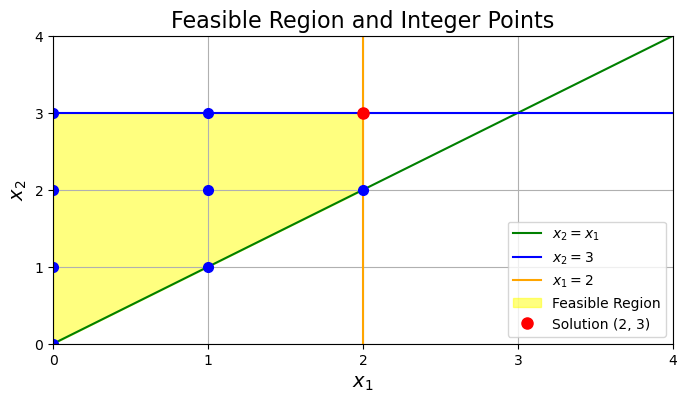

In [ ]:
# Define the limits for the plot
x1 = np.linspace(0, 4, 400)
x2_1 = x1  # Line for x2 = x1
x2_2 = np.full_like(x1, 3)  # Line for x2 = 3

# Set up the plot
plt.figure(figsize=(8, 4))

# Plot the constraints
plt.plot(x1, x2_1, label=r'$x_2 = x_1$', color='green')
plt.plot(x1, x2_2, label=r'$x_2 = 3$', color='blue')
plt.axvline(x=2, color='orange', label=r'$x_1 = 2$')

# Define the feasible region boundaries
x2_fill_upper = np.minimum(x2_2, 3)  # Upper limit for x2
x2_fill_lower = np.maximum(x2_1, 0)   # Lower limit for x2
x2_fill_upper[x1 > 2] = np.nan  # Ignore area beyond x1 = 2

# Fill the feasible region using the appropriate boundaries
plt.fill_between(x1, x2_fill_lower, x2_fill_upper, 
                 where=(x1 <= 2) & (x2_fill_upper >= x2_fill_lower), 
                 color='yellow', alpha=0.5, label='Feasible Region')


# Add all integer points in the feasible region
for x1_val in range(3):  # x1 can take values 0, 1, 2
    for x2_val in range(x1_val, 4):  # x2 starts from x1 and goes up to 3
        if x2_val <= 3:
            plt.plot(x1_val, x2_val, 'bo', markersize=7)  # Blue points for integer solutions

# Highlight the optimal solution
x1_solution = 2 
x2_solution = 3
plt.plot(x1_solution, x2_solution, 'ro', markersize=8, label=f'Solution ({x1_solution}, {x2_solution})')

# Set labels and title
plt.xlabel(r'$x_1$', fontsize=14)
plt.ylabel(r'$x_2$', fontsize=14)
plt.title('Feasible Region and Integer Points', fontsize=16)
plt.xlim(0, 4)
plt.ylim(0, 4)
plt.xticks(np.arange(0, 5, 1))
plt.yticks(np.arange(0, 5, 1))
plt.grid(True)
plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.legend()
plt.show()

#### Marginal Price Exploration

Using the interactive plot below, determine the range of validity for constraint 1 and 2.

In [79]:
# Define the marginal prices for each constraint
dual_1 = model.dual[model.constraint1]  
dual_2 = model.dual[model.constraint2]
dual_3 = model.dual[model.constraint3] 

print("================ Dual Values ================")
print("Constraint x1 <= 2 (dual_1):", f"{-1*dual_1:.2f}")
print("Constraint x2 <= 3 (dual_2):", f"{-1*dual_2:.2f}")
print("Constraint x2 >= x1 (dual_3):", f"{-1*dual_3:.2f}")

================ Dual Values ================
Constraint x1 <= 2 (dual_1): 0.00
Constraint x2 <= 3 (dual_2): -1.00
Constraint x2 >= x1 (dual_3): -1.00


In [91]:
# Function to update the plot
def plot_feasible_region(x2_limit, x1_limit):
    # Define the limits for the plot
    x1 = np.linspace(0, 4, 400)
    x2_1 = x1  # Line for x2 = x1
    x2_2 = np.full_like(x1, x2_limit)  # Upper limit for x2

    # Set up the plot
    plt.figure(figsize=(8, 4))

    # Plot the constraints
    plt.plot(x1, x2_1, label=r'$x_2 = x_1$', color='green')
    plt.plot(x1, x2_2, label=f'$x_2 = {x2_limit}$', color='blue')
    plt.axvline(x=x1_limit, color='orange', label=f'$x_1 = {x1_limit}$')

    # Fill the feasible region based on updated constraints
    plt.fill_between(x1, np.maximum(x2_1, 0), x2_2,
                     where=(x1 <= x1_limit) & (x2_2 >= np.maximum(x2_1, 0)), 
                     color='yellow', alpha=0.5, label='Feasible Region')

    # Add integer points in the feasible region
    for x1_val in range(x1_limit + 1):  # x1 can take values from 0 to x1_limit
        for x2_val in range(x1_val, min(x2_limit + 1, 4)):  # x2 starts from x1 and goes up to x2_limit
            if x2_val <= 3:
                plt.plot(x1_val, x2_val, 'bo', markersize=7)  # Blue points for integer solutions

    # Set labels and title
    plt.xlabel(r'$x_1$', fontsize=14)
    plt.ylabel(r'$x_2$', fontsize=14)
    plt.title('Feasible Region and Integer Points', fontsize=16)
    plt.xlim(0, 4)
    plt.ylim(0, 4)
    plt.xticks(np.arange(0, 5, 1))
    plt.yticks(np.arange(0, 5, 1))
    plt.grid(True)
    plt.axhline(0, color='black', lw=0.5)
    plt.axvline(0, color='black', lw=0.5)
    plt.legend()
    plt.show()

# Create sliders for x2_limit and x1_limit
x2_limit_slider = widgets.IntSlider(value=3, min=0, max=5, step=1, description='x2 limit:')
x1_limit_slider = widgets.IntSlider(value=2, min=0, max=5, step=1, description='x1 limit:')

# Use interactive output to update the plot based on slider values
widgets.interactive(plot_feasible_region, x2_limit=x2_limit_slider, x1_limit=x1_limit_slider)


interactive(children=(IntSlider(value=3, description='x2 limit:', max=5), IntSlider(value=2, description='x1 l…

### 3. MILP with Binary Variable

A key feature of MILP formulations is the potential to have a binary variable, such as $y_3$ in this formulation.

$$
\text{minimize} \quad 18x_1 + 3x_2 + 9(20y_3)
$$

$$
\text{subject to:} \quad 2x_1 + x_2 + 7(20y_3) \leq 150
$$

$$
0 \leq x_1 \leq 60
$$

$$
0 \leq x_2 \leq 30
$$

$$
x_1, x_2 \in \mathbb{R}^+
$$

$$
y_3 \in \{0, 1\}
$$


In [66]:
# Create a Pyomo model
model = ConcreteModel()

# Define decision variables
model.x1 = Var(bounds=(0, 60), within=NonNegativeReals)
model.x2 = Var(bounds=(0, 30), within=NonNegativeReals)
model.y3 = Var(within=Binary)

# Objective function
model.obj = Objective(expr=18 * model.x1 + 3 * model.x2 + 9 * 20 * model.y3, sense=minimize)

# Constraints
model.con1 = Constraint(expr=2 * model.x1 + model.x2 + 7 * 20 * model.y3 <= 150)
model.con2 = Constraint(expr=2 * model.x1 + model.x2 >= 40)

# Create a solver
solver = SolverFactory('ipopt', executable=solver_executable)

# Solve the model
solver.solve(model)

# Display the results
print(f"x1: {model.x1():.2f}")
print(f"x2: {model.x2():.2f}")
print(f"y3: {int(model.y3())}")

# Print full model details (optional)
#model.pprint()

x1: 5.00
x2: 30.00
y3: 0
